In [1]:
import sys
sys.path.append('../scripts/')

from time import time
import glob
import warnings
import param

import numpy as np
import pandas as pd
import xarray as xr
from scipy.special import gammaln
from scipy.optimize import curve_fit, minimize
from scipy.stats import pearsonr

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.xarray

from epsilon_tools import *
from tools import str2date, avg_funs

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='notebook', palette='colorblind',font_scale=1.5)
mpl.rc('figure', dpi=100, figsize=[11, 5])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

%matplotlib inline

In [2]:
ds = xr.open_dataset('../data/chi/test.nc')

(5.0, 3000.0)

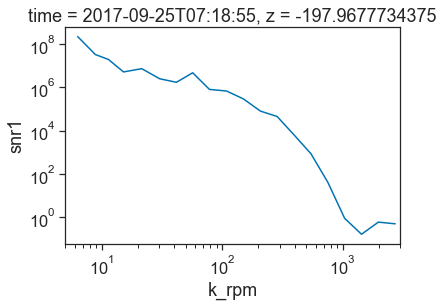

In [3]:
ds.isel(time=230).snr1.plot(x='k_rpm')
plt.yscale('log')
plt.xscale('log')
plt.xlim(5e0,3e3)
# plt.ylim(1e-9,1e-3)

In [126]:
ds['itime'] = ('time',np.arange(0,len(ds.time)))

In [152]:
hover_cols = ['eps_rc','chi1','lhr1_bat','A1']
arguments = {'hover_cols':hover_cols,'legend':'left','groupby':'itime','loglog':True}

obs = ds.hvplot(x='k_rpm',y='corrdTdzsp1_rpm',label='Observed',**arguments)
noi = ds.hvplot(x='k_rpm',y='noise_rpm',label='Noise',line_dash='dotted',**arguments)
bat = ds.hvplot(x='k_rpm',y='bat1',label='Batchelor',**arguments)
krai = ds.hvplot(x='k_rpm',y='kra1',label='Kraichnan',**arguments)
power = ds.hvplot(x='k_rpm',y='power1',label='Power law',line_dash='dashed',**arguments)
rc = ds.hvplot(x='k_rpm',y='bat1_rc',label='Ren-Chieh',**arguments)

In [153]:
(obs*bat*krai*rc*power*noi).options(height=600,ylim=(1e-9, 1e-2),xlim=(1e1,2e3),
                      title=f'Temperature Gradient Spectra',
                      xlabel=r'k_z',ylabel='dPhidz',
                      fontsize={'title': 16, 'labels': 14, 'xticks': 12, 'yticks': 12, 'legend':12})

:DynamicMap   [itime]
   :Overlay
      .Curve.Observed               :Curve   [k_rpm]   (corrdTdzsp1_rpm,eps_rc,chi1,lhr1_bat,A1)
      .Curve.Batchelor              :Curve   [k_rpm]   (bat1,eps_rc,chi1,lhr1_bat,A1)
      .Curve.Kraichnan              :Curve   [k_rpm]   (kra1,eps_rc,chi1,lhr1_bat,A1)
      .Curve.Ren_hyphen_minus_Chieh :Curve   [k_rpm]   (bat1_rc,eps_rc,chi1,lhr1_bat,A1)
      .Curve.Power_law              :Curve   [k_rpm]   (power1,eps_rc,chi1,lhr1_bat,A1)
      .Curve.Noise                  :Curve   [k_rpm]   (noise_rpm,eps_rc,chi1,lhr1_bat,A1)

In [195]:
pick = ds.isel(time=88)

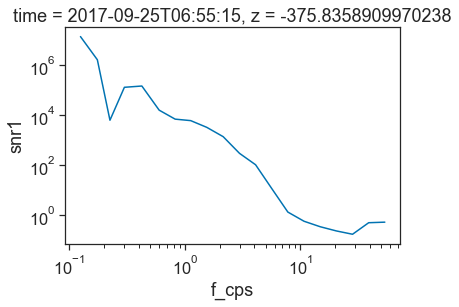

In [196]:
pick.snr1.plot()
plt.xscale('log')
plt.yscale('log')

In [197]:
print(pick.l1, pick.l1_kra, pick.l1_kra-pick.l1, (pick.l1_kra-pick.l1)*np.log10(np.exp(1)) )

<xarray.DataArray 'l1' ()>
array(142.206494)
Coordinates:
    time     datetime64[ns] 2017-09-25T06:55:15
    z        float64 -375.8 <xarray.DataArray 'l1_kra' ()>
array(80.756879)
Coordinates:
    time     datetime64[ns] 2017-09-25T06:55:15
    z        float64 -375.8 <xarray.DataArray ()>
array(-61.44961531)
Coordinates:
    time     datetime64[ns] 2017-09-25T06:55:15
    z        float64 -375.8 <xarray.DataArray ()>
array(-26.68722884)
Coordinates:
    time     datetime64[ns] 2017-09-25T06:55:15
    z        float64 -375.8


(1e-12, 0.001)

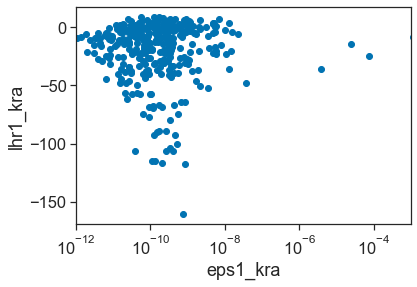

In [198]:
ds.plot.scatter(x='eps1_kra',y='lhr1_kra')
# plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-12,1e-3)
# plt.ylim(1e-12,1e-3)

In [107]:
ds['log_eps_rc'] = np.log10(ds.eps_rc)
ds['log_eps1_bat'] = np.log10(ds.eps1_bat)
ds['log_eps1_kra'] = np.log10(ds.eps1_kra)

/usr/local/anaconda3/envs/epsilon-env/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


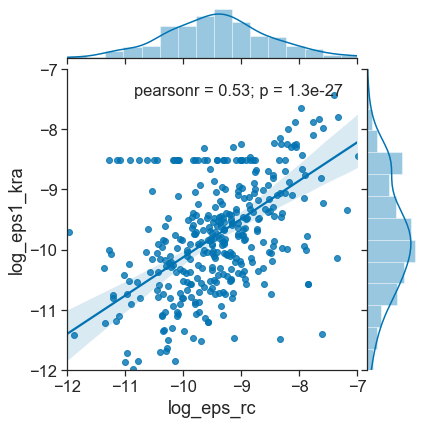

In [133]:
sns.jointplot(x='log_eps_rc',y='log_eps1_kra',data=ds, kind='reg',dropna=True, stat_func=pearsonr,
             xlim=(-12,-7),ylim=(-12,-7))

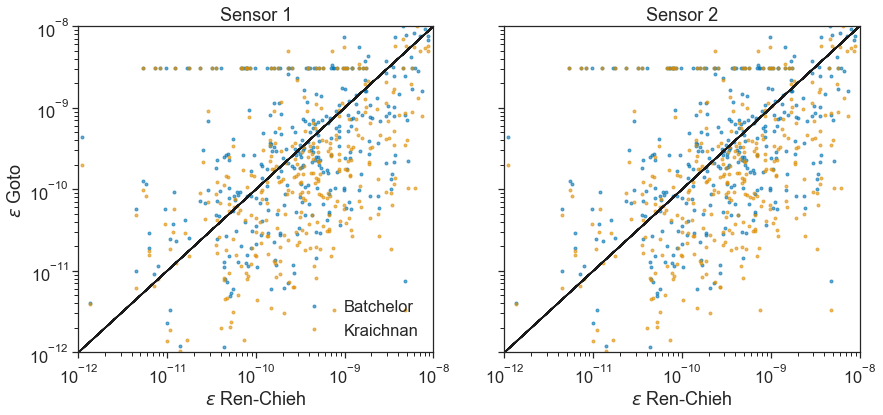

In [109]:
f,ax = plt.subplots(1,2,figsize=(14,6), sharey =True)
ax[0].plot( ds.eps_rc, ds.eps1_bat,'.',label='Batchelor', alpha=0.6)
ax[0].plot( ds.eps_rc, ds.eps1_kra,'.',label='Kraichnan', alpha=0.6)

ax[0].plot( ds.eps_rc, ds.eps_rc, color='k')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlim(1e-12,1e-8)
ax[0].set_ylim(1e-12,1e-8)
ax[0].set_xlabel(r'$\epsilon$ Ren-Chieh')
ax[0].set_ylabel(r'$\epsilon$ Goto')
ax[0].set_title(r'Sensor 1')
ax[0].legend()

ax[1].plot( ds.eps_rc, ds.eps2_bat,'.',label='Batchelor', alpha=0.6)
ax[1].plot( ds.eps_rc, ds.eps2_kra,'.',label='Kraichnan', alpha=0.6)
ax[1].plot( ds.eps_rc, ds.eps_rc, color='k')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlim(1e-12,1e-8)
ax[1].set_ylim(1e-12,1e-8)
ax[1].set_xlabel(r'$\epsilon$ Ren-Chieh')
ax[1].set_title(r'Sensor 2')
plt.savefig('../figures/scatter_goto_vs_rc_2sensors.pdf')
plt.show()

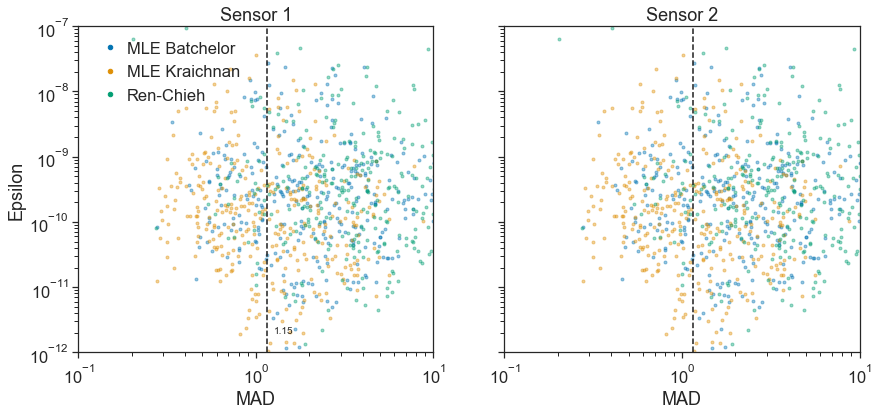

In [110]:
def plot_mad(ax,ds,sensor,mad_max,title,ylabel,xlabel):
    if sensor==1:
        ax.plot( ds.mad1_bat, ds.eps1_bat,'.',label='MLE Batchelor', alpha=0.4)
        ax.plot( ds.mad1_kra, ds.eps1_kra,'.',label='MLE Kraichnan', alpha=0.4)
        ax.plot( ds.mad1_rc, ds.eps_rc,'.',label='Ren-Chieh', alpha=0.4)
        ax.annotate(f'{mad_max:1.2f}',(mad_max+0.1,2e-12))
        leg = ax.legend(handletextpad=0.05, markerscale=1.5)
        ax.set_ylabel(ylabel)
        for lh in leg.legendHandles: 
            lh._legmarker.set_alpha(1)
    elif sensor==2:
        ax.plot( ds.mad2_bat, ds.eps2_bat,'.',label='MLE Batchelor', alpha=0.4)
        ax.plot( ds.mad2_kra, ds.eps2_kra,'.',label='MLE Kraichnan', alpha=0.4)
        ax.plot( ds.mad2_rc, ds.eps_rc,'.',label='Ren-Chieh', alpha=0.4)
    else:
        raise ValueError('Only 2 sensors!')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(1e-1,1e1)
    ax.set_ylim(1e-12,1e-7)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.axvline(mad_max, color='k', ls='dashed')
    
mad_max = 2*np.sqrt(2/6)
f,ax = plt.subplots(1,2,figsize=(14,6), sharey =True)
plot_mad(ax[0],ds,1,mad_max,'Sensor 1','Epsilon','MAD')
plot_mad(ax[1],ds,2,mad_max,'Sensor 2','Epsilon','MAD')

plt.savefig('../figures/scatter_mad_vs_eps_2sensors.pdf')
plt.show()

(array([10., 19., 33., 52., 60., 80., 72., 39., 19.,  6.]),
 array([ 4.86869066,  5.392564  ,  5.91643734,  6.44031067,  6.96418401,
         7.48805735,  8.01193069,  8.53580403,  9.05967737,  9.58355071,
        10.10742404]),
 <a list of 10 Patch objects>)

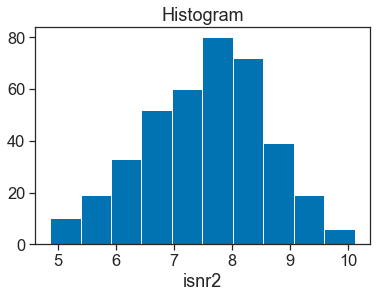

In [116]:
ds.isnr2.pipe(np.log10).plot.hist()

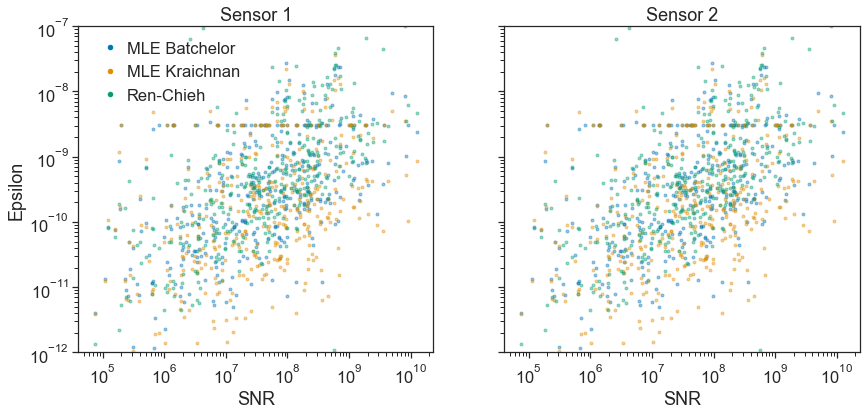

In [119]:
def plot_mad(ax,ds,sensor,mad_max,title,ylabel,xlabel):
    if sensor==1:
        ax.plot( ds.isnr1, ds.eps1_bat,'.',label='MLE Batchelor', alpha=0.4)
        ax.plot( ds.isnr1, ds.eps1_kra,'.',label='MLE Kraichnan', alpha=0.4)
        ax.plot( ds.isnr1, ds.eps_rc,'.',label='Ren-Chieh', alpha=0.4)
#         ax.annotate(f'{mad_max:1.2f}',(mad_max+0.1,2e-12))
        leg = ax.legend(handletextpad=0.05, markerscale=1.5)
        ax.set_ylabel(ylabel)
        for lh in leg.legendHandles: 
            lh._legmarker.set_alpha(1)
    elif sensor==2:
        ax.plot( ds.isnr2, ds.eps2_bat,'.',label='MLE Batchelor', alpha=0.4)
        ax.plot( ds.isnr2, ds.eps2_kra,'.',label='MLE Kraichnan', alpha=0.4)
        ax.plot( ds.isnr2, ds.eps_rc,'.',label='Ren-Chieh', alpha=0.4)
    else:
        raise ValueError('Only 2 sensors!')
    ax.set_yscale('log')
    ax.set_xscale('log')
#     ax.set_xlim(1e-1,1e1)
    ax.set_ylim(1e-12,1e-7)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
#     ax.axvline(mad_max, color='k', ls='dashed')
    
mad_max = 2*np.sqrt(2/6)
f,ax = plt.subplots(1,2,figsize=(14,6), sharey =True)
plot_mad(ax[0],ds,1,mad_max,'Sensor 1','Epsilon','SNR')
plot_mad(ax[1],ds,2,mad_max,'Sensor 2','Epsilon','SNR')

plt.savefig('../figures/scatter_mad_vs_eps_2sensors.pdf')
plt.show()

(array([  1.,   4.,   5.,   6.,   9.,  17.,  57.,  93., 128.,  21.]),
 array([-239.22381542, -194.08896349, -148.95411156, -103.81925963,
         -58.6844077 ,  -13.54955577,   31.58529616,   76.72014809,
         121.85500002,  166.98985195,  212.12470388]),
 <a list of 10 Patch objects>)

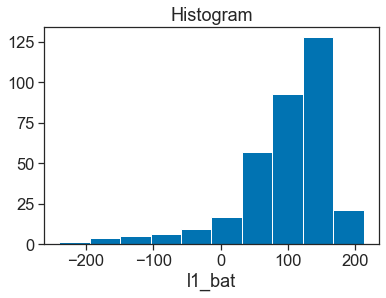

In [145]:
ds.l1_bat.where(np.isfinite(ds.l1_bat)).plot.hist()

In [146]:
ds['lhr1_bat'] =  (ds.l1_bat-ds.l1)*np.log10(np.exp(1))
ds['lhr1_kra'] =  (ds.l1_bat-ds.l1)*np.log10(np.exp(1))
ds['lhr2_bat'] =  (ds.l2_bat-ds.l2)*np.log10(np.exp(1))
ds['lhr2_kra'] =  (ds.l2_kra-ds.l2)*np.log10(np.exp(1))

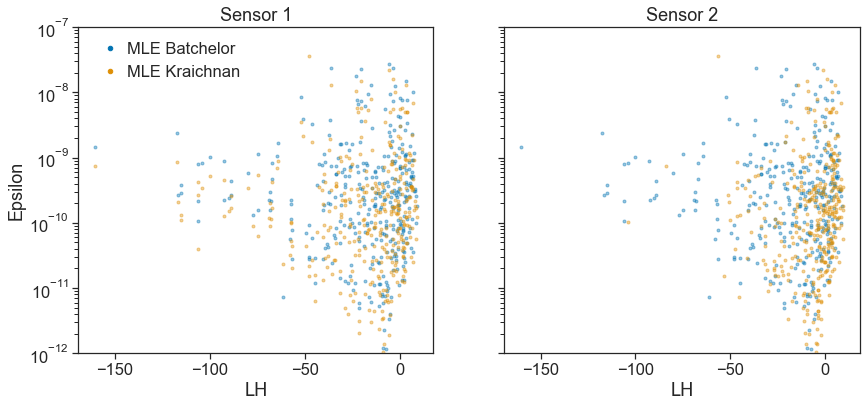

In [147]:
def plot_mad(ax,ds,sensor,mad_max,title,ylabel,xlabel):
    if sensor==1:
        ax.plot( ds.lhr1_bat, ds.eps1_bat,'.',label='MLE Batchelor', alpha=0.4)
        ax.plot( ds.lhr1_kra, ds.eps1_kra,'.',label='MLE Kraichnan', alpha=0.4)
#         ax.plot( ds.isnr1, ds.eps_rc,'.',label='Ren-Chieh', alpha=0.4)
#         ax.annotate(f'{mad_max:1.2f}',(mad_max+0.1,2e-12))
        leg = ax.legend(handletextpad=0.05, markerscale=1.5)
        ax.set_ylabel(ylabel)
        for lh in leg.legendHandles: 
            lh._legmarker.set_alpha(1)
    elif sensor==2:
        ax.plot( ds.lhr2_bat, ds.eps2_bat,'.',label='MLE Batchelor', alpha=0.4)
        ax.plot( ds.lhr2_kra, ds.eps2_kra,'.',label='MLE Kraichnan', alpha=0.4)
#         ax.plot( ds.isnr2, ds.eps_rc,'.',label='Ren-Chieh', alpha=0.4)
    else:
        raise ValueError('Only 2 sensors!')
    ax.set_yscale('log')
#     ax.set_xscale('log')
#     ax.set_xlim(-10,10)
    ax.set_ylim(1e-12,1e-7)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
#     ax.axvline(mad_max, color='k', ls='dashed')
    
mad_max = 2*np.sqrt(2/6)
f,ax = plt.subplots(1,2,figsize=(14,6), sharey =True)
plot_mad(ax[0],ds,1,mad_max,'Sensor 1','Epsilon','LH')
plot_mad(ax[1],ds,2,mad_max,'Sensor 2','Epsilon','LH')

plt.savefig('../figures/scatter_lhr_vs_eps_2sensors.pdf')
plt.show()

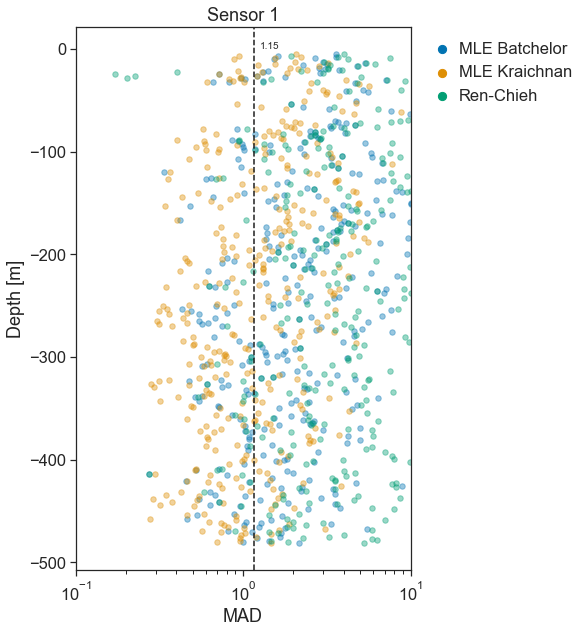

In [92]:
def scatter_mad_w_depth(ax,ds,sensor,mad_max,title,ylabel,xlabel):
    s=30
    if sensor==1:
        ax.scatter( ds.mad1_bat,ds.z,s,label='MLE Batchelor', alpha=0.4, color=None)
        ax.scatter( ds.mad1_kra,ds.z,s,label='MLE Kraichnan', alpha=0.4)
        ax.scatter( ds.mad1_rc,ds.z,s,label='Ren-Chieh', alpha=0.4)
        ax.annotate(f'{mad_max:1.2f}',(mad_max+0.1,2e-12))
        leg = ax.legend(handletextpad=0.05, markerscale=1.5, loc='upper left',
               bbox_to_anchor=(1, 1))
        ax.set_ylabel(ylabel)
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
    elif sensor==2:
        ax.scatter( ds.mad2_bat,ds.z,s,label='MLE Batchelor', alpha=0.4)
        ax.scatter( ds.mad2_kra,ds.z,s,label='MLE Kraichnan', alpha=0.4)
        ax.scatter( ds.mad2_rc,ds.z,s,label='Ren-Chieh', alpha=0.4)
    else:
        raise ValueError('Only 2 sensors!')
#     ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(1e-1,1e1)
#     ax.set_ylim(1e-12,1e-7)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.axvline(mad_max, color='k', ls='dashed')
    
mad_max = 2*np.sqrt(2/6)
f,ax = plt.subplots(1,1,figsize=(6,10), sharey =True)
scatter_mad_w_depth(ax,ds,1,mad_max,'Sensor 1','Depth [m]','MAD')
plt.savefig('../figures/scatter_mad_vs_depth.pdf')
plt.show()

In [93]:
ds['var_y_bat1'] = ds.y_bat1.var(dim='f_cps')

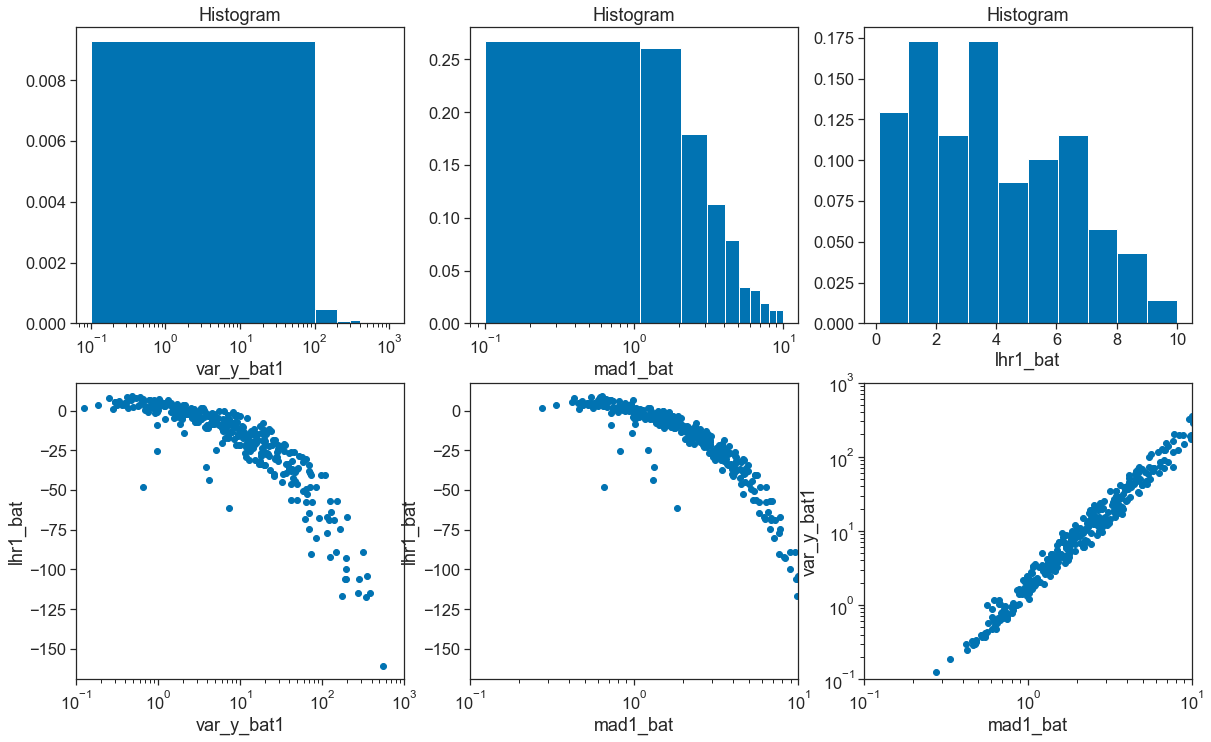

In [100]:
f,ax = plt.subplots(2,3,figsize=(20,12))
ds.var_y_bat1.plot.hist(density=True, range=(1e-1,1e3), xscale='log', ax=ax[0,0])
ds.mad1_bat.plot.hist(density=True, range=(1e-1,1e1), xscale='log', ax=ax[0,1])
ds.lhr1_bat.plot.hist(density=True, range=(1e-1,1e1), xscale='linear', ax=ax[0,2])

ds.plot.scatter(x='var_y_bat1', y='lhr1_bat', ax=ax[1,0])
ax[1,0].set_xscale('log')
ax[1,0].set_xlim(1e-1,1e3)

ds.plot.scatter(x='mad1_bat', y='lhr1_bat', ax=ax[1,1])
ax[1,1].set_xscale('log')
ax[1,1].set_xlim(1e-1,1e1)

ds.plot.scatter(x='mad1_bat', y='var_y_bat1', ax=ax[1,2])
ax[1,2].set_xscale('log')
ax[1,2].set_yscale('log')
ax[1,2].set_xlim(1e-1,1e1)
ax[1,2].set_ylim(1e-1,1e3)

plt.subplots_adjust()
plt.show()